# Проект по А/B-тестированию

Наша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Необходимо:

- оценить корректность проведения теста;
- проанализировать результаты теста.

Чтобы оценить корректность проведения теста, нужно проверить:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

# Содержание

1. Техническое задание и описание данных
2. Загрузка и анализ данных
3. Предобработка данных
4. Оценка корректности теста
5. Исследовательский анализ данных
6. Оценка результатов A/B тестирования

## Техническое задание и описание данных

**Техническое задание**

- Название теста: recommender_system_test;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
  - конверсии в просмотр карточек товаров — событие product_page,
  - просмотры корзины — product_cart,
  - покупки — purchase.

**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Загрузка и анализ данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import datetime as dt
from datetime import datetime, timedelta

from scipy import stats as st
import math as mth
from statsmodels.stats.weightstats import ztest as ztest

import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

In [2]:
user_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
pm_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [3]:
datasets_list = [user_events, pm_events, new_users, participants]
name_list = ['user_events', 'pm_events', 'new_users', 'participants']

In [4]:
for df, name  in zip (datasets_list, name_list):
    print()
    print ('\033[1m'+'Общая информация о DataFrame', name)
    display (df.head())
    df.info()
    print ()
    print ('Количество дубликатов = ', df.duplicated().sum())
    print ('Количество строк/столбцов -> ', df.shape)
    print ()


Общая информация о DataFrame user_events


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Количество дубликатов =  0
Количество строк/столбцов ->  (440317, 4)


Общая информация о DataFrame pm_events


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

Количество дубликатов =  0
Количество строк/столбцов ->  (14, 4)


Общая информация о DataFrame new_users


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Количество дубликатов =  0
Количество строк/столбцов ->  (61733, 4)


Общая информация о DataFrame participants


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Количество дубликатов =  0
Количество строк/столбцов ->  (18268, 3)



Оценим количество пропусков в events ['details']

In [5]:
print(round (1 - user_events['details'].count()/user_events.shape[0], 2))

0.86


In [6]:
user_events.groupby('event_name')['details'].count()

event_name
login               0
product_cart        0
product_page        0
purchase        62740
Name: details, dtype: int64

В таблице events имеем большое количество пропусков (порядка 86%) в столбце details. Данное поле несет в себе информацию о стоимости покупки и заполнено только для события purchase. Т.е. пропуски абсолютно естественны.

Таким образом пропуски зависят от данных, их нельзя отбрасывать, т.к. это приведёт к заметным искажениям

**Вывод:**

На данном шаге познакомились с данными:

- дубликаты отсутсвуют;
- пропуски есть только в столбце events['details'], но носят естественный характер

## Предобработка данных

Приведем столбцы к нужным типам

In [7]:
# преобразование типов данных
pm_events['start_dt'] = pm_events['start_dt'].astype('datetime64[D]')
pm_events['finish_dt'] = pm_events['finish_dt'].astype('datetime64[D]')

new_users['first_date'] = new_users['first_date'].astype('datetime64[D]')

user_events['event_dt_time'] = pd.to_datetime(user_events['event_dt'], format='%Y-%m-%d %H:%M:%S')
user_events['event_dt'] = user_events['event_dt'].astype('datetime64[D]')

## Оценка корректности теста

### Проверка корректности ТЗ

In [8]:
# считаем количество записей по каждому тесту
participants.groupby('ab_test')['user_id'].count()

ab_test
interface_eu_test          11567
recommender_system_test     6701
Name: user_id, dtype: int64

In [9]:
# считаем количество записей для групп A и В для теста 'recommender_system_test'
participants.query("ab_test == 'recommender_system_test'").groupby('group')['user_id'].count()

group
A    3824
B    2877
Name: user_id, dtype: int64

В искомом тесте recommender_system_test присутствуют 6 701 запись, разделение на группы в тесте также есть.

In [10]:
new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

In [11]:
# делаем фильтр до 21 декабря
new_new_users = new_users[new_users['first_date'] <= "2020-12-21 00:00:00"]

In [12]:
new_new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [13]:
# фильтр по нужному нам тесту
recom_users = new_new_users[new_new_users['user_id'].isin(participants.query('ab_test == "recommender_system_test"')['user_id'])]

In [14]:
# проверяем даты запуска теста и дата окончания набора новых пользователей
display(recom_users['first_date'].min())
recom_users['first_date'].max()

Timestamp('2020-12-07 00:00:00')

Timestamp('2020-12-21 00:00:00')

Даты запуска теста и дата окончания набора новых пользователей верны - 7 и 21 декабря 2020

In [15]:
#смотрим дату последнего события
user_events['event_dt'].max()

Timestamp('2020-12-30 00:00:00')

Записи в таблице с событиями завершаются датой 30-12-2020. Это не хорошо, ведь у нас не все пользователи будут иметь возможность совершать события в первые 14 дней после регистрации.

In [16]:
display(recom_users['region'].value_counts())
display(new_new_users['region'].value_counts())

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: region, dtype: int64

In [17]:
# Считаем процент пользователей из EU
round((recom_users.query('region == "EU"')['region'].count()/new_new_users.query('region == "EU"')['region'].count())*100,2)

15.0

Аудитория теста - это в основном пользователи из Европы, также присутствуют пользователи из других стран. По ТЗ сказано, что аудиторией теста должны быть 15% новых пользователей из региона EU, по данным видно, что аудитория из Европы составляет 6351 из всех 43340 новых клиентов с этого региона, что соответствует ТЗ в 15%.

### Время проведения теста

Проверим время и географию проведения маркетинговых компаний и сравним со временем проведения нашего теста. По условию задачи набор новых пользователей проводился с 07.12.2020 по 21.12.2020 и ориентирован на регион EU, окончен тест был 04.01.2021.

In [18]:
# сравниваем периоды маркетинговых активностей со временем набора пользователей
pm_events.query("start_dt>datetime(2020,12,7) & start_dt<datetime(2020,12,21)")

,name,regions,start_dt,finish_dt


In [19]:
# сравниваем периоды маркетинговых активностей с общим периодом проведения теста.
pm_events.query("start_dt>datetime(2020,12,7) & start_dt<datetime(2021,1,4)")

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


В наш временной период попадают 2 акции. Акция Christmas&New Year Promo может оказать большее влияние, т.к. даты её проведения попадают в исследуемый период с 12 декабря - по 4 января, плюс эта акция проводится в регионе EU, именно этот регион преобладает в тесте.

### Проверка аудитории теста

Проверим нет ли у нас пользователей попавших в оба теста одновременно.

In [20]:
# отбираем группы  
group_a=participants.query("ab_test == 'recommender_system_test'") 
group_b=participants.query("ab_test == 'interface_eu_test'") 
  
# получаем id пользователей, попавших в обе группы 
group_intersections=list(np.intersect1d(group_a['user_id'], group_b['user_id']))
print ('Количество пользователей, попавших в обе группы = ', len(group_intersections))
print ('Доля пользователей, попавших в обе группы = ', round (len(group_intersections)/participants.shape[0],2))

Количество пользователей, попавших в обе группы =  1602
Доля пользователей, попавших в обе группы =  0.09


Получаем 1 602 пользователя участвовавших в обоих тестах. Сказать какой из тестов повлиял на их решение мы не можем, поэтому оставлять информацию о них в данных нельзя, это может исказить результаты.

In [21]:
# удаляем данные о пользователях попавших в оба теста
participants = participants.query('user_id not in @group_intersections')

Теперь проверим нет ли пользователей, участвующих в двух группах одновременно

In [22]:
# отбираем группы  
group_a=participants.query('group == "A"') 
group_b=participants.query('group == "B"') 
  
# получаем id пользователей, попавших в обе группы 
group_intersections=list(np.intersect1d(group_a['user_id'], group_b['user_id']))
print ('Количество пользователей, попавших в обе группы = ', len(group_intersections))
print ('Доля пользователей, попавших в обе группы = ', round (len(group_intersections)/participants.shape[0],2))

Количество пользователей, попавших в обе группы =  0
Доля пользователей, попавших в обе группы =  0.0


Также уберем из данных записи о interface_eu_test, т.к. для нашей работы они нам не нужны.

In [23]:
participants = participants.query("ab_test == 'recommender_system_test'")
len (participants)

5099

Остались записи только 5 099 пользователях.

Проверим сколько пользователей у нас попали в каждую из групп.

In [24]:
print ('Количество пользователей в группе A = ', len(participants.query('group == "A"')))
print ('Количество пользователей в группе B = ', len(participants.query('group == "B"')))
print ('Доля пользователей группы A  = ', round(len(participants.query('group == "A"')) / len (participants), 2))
print ('Доля пользователей группы B  = ', round(len(participants.query('group == "B"')) / len (participants), 2))

Количество пользователей в группе A =  2903
Количество пользователей в группе B =  2196
Доля пользователей группы A  =  0.57
Доля пользователей группы B  =  0.43


In [25]:
# объединяем таблицы 
participants_events  = recom_users.merge(participants.query('ab_test == "recommender_system_test"'), on='user_id')
display(participants_events.user_id.nunique())
participants_events  = participants_events.merge(user_events, how='left', on='user_id')
display(participants_events.user_id.nunique())

5099

5099

In [26]:
# делаем фильтр в 14 дней

#горизонт событий - 14 дней, 
#последняя дата наблюдения - 4 января, 
#последняя подходящая для анализа дата (4 января - 14 дней) 

horizon_days = 14
observation_date = datetime(2021, 1, 4).date()
last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)

#фильтруем по дате последнего набора пользователей 
#добавляем лайфтайм пользователя
#делаем по нему фильтр в 14 дней 
display(participants_events.user_id.nunique())
test_1 = participants_events
recom_users_ab = participants_events.query('event_dt <= @last_suitable_acquisition_date')
display(participants_events.user_id.nunique())
participants_events['lifetime'] = (participants_events['event_dt'] - participants_events['first_date']).dt.days
participants_events = participants_events.query('lifetime < 14')
display(participants_events.user_id.nunique())

5099

5099

2788

Всего 2 788, т.е. гораздо меньше чем ожидалось в ТЗ.

In [27]:
participants_events.lifetime.nunique()

14

**Вывод**

На данном шаге проверили корректность теста. Были выявлены пересечения с другим тестом. Записи о пользователях попавших в оба теста пришло удалить.

Кроме этого, при проверке данных о тесте представленных для анализа выявлены серьезные проблемы, в частности:

- время и география проведения теста пересекается с маркетинговой акцией Christmas&New Year Promo;
- количество участников теста более чем в два раза меньше чем указано в ТЗ.

## Исследовательский анализ данных

### Распределение количества событий на пользователя

In [28]:
print ('Усредненное количество событий на пользователя в группе А = ', \
    round (participants_events.query('group == "A"')['event_name'].count() / participants_events.query('group == "A"')['user_id'].nunique(), 0))

Усредненное количество событий на пользователя в группе А =  7.0


In [29]:
print ('Усредненное количество событий на пользователя в группе B = ', \
    round (participants_events.query('group == "B"')['event_name'].count() / participants_events.query('group == "B"')['user_id'].nunique(), 0))

Усредненное количество событий на пользователя в группе B =  5.0


События распределены схоже но неравномерно, т.к. в группе А гораздо больше пользователей

### Распределение числа событий по дням

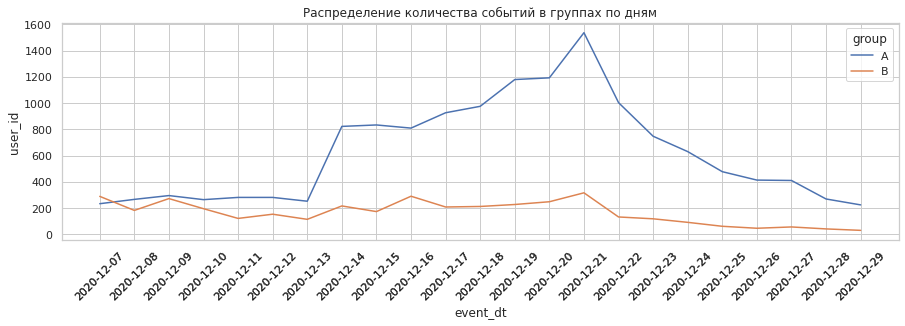

In [30]:
# создаем DataFrame event_by_date, на основнаии которого будем строить гарфик
event_by_date = participants_events.groupby(['event_dt', 'group'])['user_id'].count().reset_index()

# строим график
plt.figure(figsize=(15, 4))
sns.set_style("whitegrid")
ax = sns.lineplot(data=event_by_date, x='event_dt', y='user_id', hue='group')
ax.set_xticks(event_by_date['event_dt'])
ax.set_title('Распределение количества событий в группах по дням')
plt.xticks(rotation=45);

- наблюдается резкий рост числа событий в группе А в период с 13 по 21 декабря;
- 30 декабря количество событий в группе B падает до нуля, а по группе A вообще нет информации.

In [31]:
# соберем все необходимые для дальнейшей работы данные в одну таблицу
df_all_data = participants_events.merge(new_users, how='left', on='user_id').dropna(axis='index', how='any',subset=['group'])

### Изменение конверсии в воронке

In [32]:
# определяем переменные для создания воронки
funnel_A = participants_events[participants_events['group']=="A"].groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'})
funnel_A.columns = ['event_count','user_count']
funnel_A = funnel_A.sort_values(by = 'event_count', ascending = False).reset_index()

funnel_B = participants_events[participants_events['group']=="B"].groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'})
funnel_B.columns = ['event_count','user_count']
funnel_B = funnel_B.sort_values(by = 'event_count', ascending = False).reset_index()

Сначало пользователь совершает "login" (вход) затем заходит на "product_page"(карту товара), затем по логике он идет в корзину (product_cart), и потом совершает покупку (purchase).

In [33]:
funnel_A

,event_name,event_count,user_count
0,login,6345,2082
1,product_page,4126,1360
2,product_cart,1940,631
3,purchase,1929,652


In [34]:
funnel_B

,event_name,event_count,user_count
0,login,1849,705
1,product_page,982,397
2,product_cart,506,195
3,purchase,477,198


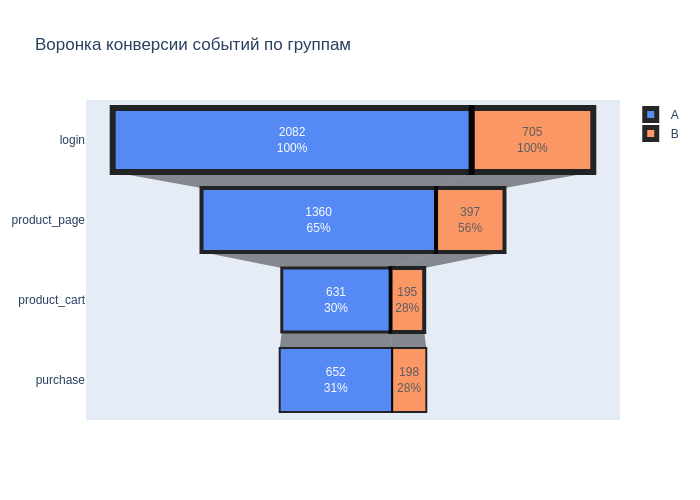

In [35]:
# строим воронку конверсии событий по группам

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel_A['event_name'],
    x = funnel_A['user_count'],
    opacity = 0.85, marker = {"color": ["#3C79F5", "#3C79F5", "#3C79F5", "#3C79F5"],
    "line": {"width": [6, 4, 3, 2, 1], "color": ["black", "black", "black", "black"]}},
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = funnel_B['event_name'],
    x = funnel_B['user_count'],
    opacity = 0.85, marker = {"color": ["#FF884B", "#FF884B", "#FF884B", "#FF884B"],
    "line": {"width": [6, 4, 4, 2, 1], "color": ["black", "black", "black", "black"]}},
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title_text = 'Воронка конверсии событий по группам')
fig.show("png")

**Вывод:**

До покупки доходят 31% пользователей группы А и 28% пользователей группы В. Меньше всего разница в конверсии между product_cart и purchase - добавлением товара в корзине и его покупкой (разница в 1% у группы А и у группы В нет разницы) Больше всего падает конверсия между login и product_page уровнями - логином и просмотром страницы товара (-35% у группы А и -44% у группы В)

## Оценка результатов A/B тестирования

### Конверсия

Изучим кумулятивную конверсию по значимым событиям для каждой из групп. Для это вначале опишем функции по сбору кумулятивных данных и построению графиков.

In [36]:
def cumulative_data(df, event):
    
    """       
        Функция создает DataFrame c агрегированными кумулятивными данными о пользователях по дням.
        Таким образом при вызове функции получим DataFrame, где будут находиться такие данные,
        как будто мы ежедневно считали результаты тестирования до выбранного дня включительно и сохраняли
        их в строках таблиц.             
        
    """
    # Выбираем из данных строки с заданным событием
    df_filtred_event = df.query('event_name == @event')
    # Создадим массив уникальных пар значений дат и групп теста 
    datesGroups = df_filtred_event[['event_dt','group']].drop_duplicates()
    
    # Соберём агрегированные кумулятивные данные о покупках по дням
    df_purchase_agg = datesGroups.apply(lambda x: df_filtred_event[np.logical_and(df_filtred_event['event_dt'] <= x['event_dt'],
                                                                           df_filtred_event['group'] == x['group'])]
                                      .agg({'event_dt': 'max', 'group': 'max', 'user_id': 'nunique'}),
                                                                            axis=1).sort_values(by=['event_dt','group'])
    
    # Соберём агрегированные кумулятивные данные о покупателях
    df_buyers_agg = datesGroups.apply(lambda x: df_filtred_event[np.logical_and(df_filtred_event['event_dt'] <= x['event_dt'],
                                                                         df_filtred_event['group'] == x['group'])]
                                    .agg({'event_dt': 'max', 'group': 'max', 'user_id': 'count'}),
                                                                            axis=1).sort_values(by=['event_dt','group'])
    
    # Объединим кумулятивные данные в одной таблице и переименуем столбцы
    result = df_purchase_agg.merge(df_buyers_agg, on=['event_dt','group'])
    result.columns = ['date', 'group', 'visitors', 'orders']
    return result

In [37]:
# Соберём кумулятивные значения для анализа относительных показателей и события "просмотр карточек"
cumulativeData_product_page = cumulative_data(df_all_data, 'product_page')

# добавляем столбец расчета конверсии
cumulativeData_product_page['conversion'] = cumulativeData_product_page['orders']/cumulativeData_product_page['visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeData_product_page_A = cumulativeData_product_page.query('group == "A"')

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе В
cumulativeData_product_page_B = cumulativeData_product_page.query('group == "B"')

In [38]:
# Функция построения сравнительного графика
def plot_conversion(cumulativeData_A, cumulativeData_B, column, date, title, ylabel):
    
    """ 
        Функция для отображения кумулятивной конверсии в разбивке по группам
    
    """
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(18,6))
    ax.set(title=title, xlabel='дата', ylabel=ylabel)
    ax.plot(cumulativeData_A['date'], cumulativeData_A[column])
    ax.plot(cumulativeData_B['date'], cumulativeData_B[column])
    ax.plot(cumulativeData_A['date'], cumulativeData_A[column], '.-',label='A')
    ax.plot(cumulativeData_B['date'], cumulativeData_B[column], '.-',label='B' )
    ax.legend() 
    

    plt.show()

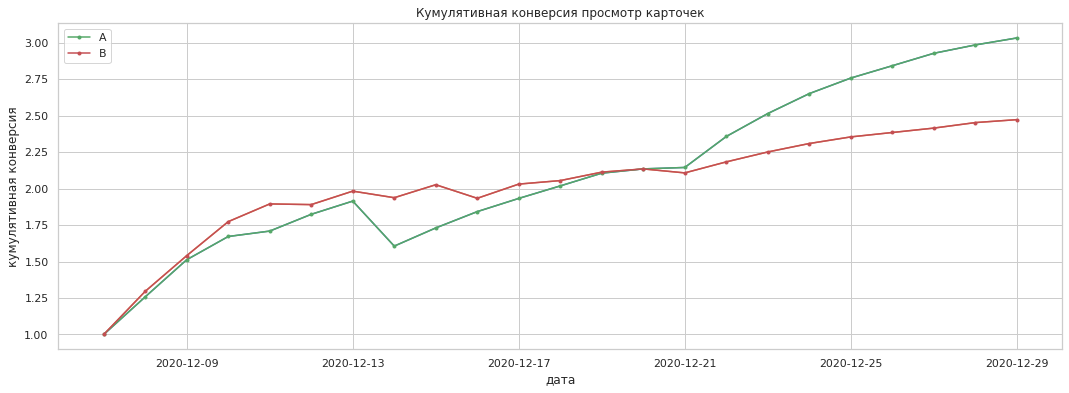

In [39]:
# построение графика
plot_conversion(cumulativeData_product_page_A, cumulativeData_product_page_B,
                'conversion', 'date', 'Кумулятивная конверсия просмотр карточек', 'кумулятивная конверсия')

взглянув на график, можем отметить следующее:

- до 9 декабря в обоих группах темп роста кумулятивной конверсии в просмотр карточек рос с одинаковым темпом, и был почти равен;
- затем данный показатель в группе B колебался возле значения 1,9-2,1 до 21 декабря, а в группе A наблюдался резкий спад 14 декабря;
- после этого темп роста показателя кумулятивной конверсии в просмотр карточек для группы A начал значительно увеличиваться и после 21 декабря перегнал показатель группы B.

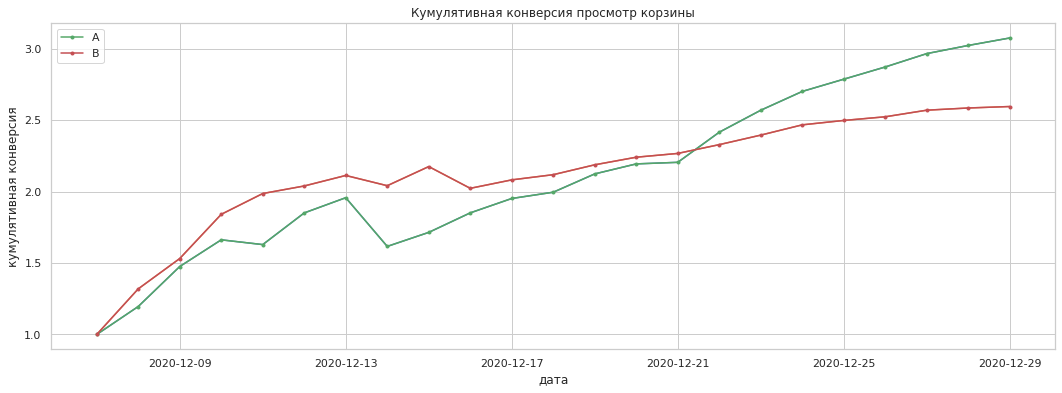

In [40]:
# аналогично для корзины
cumulativeData_product_cart = cumulative_data(df_all_data, 'product_cart')
cumulativeData_product_cart['conversion'] = cumulativeData_product_cart['orders']/cumulativeData_product_cart['visitors']
cumulativeData_product_cart_A = cumulativeData_product_cart.query('group == "A"')
cumulativeData_product_cart_B = cumulativeData_product_cart.query('group == "B"')

# построение графика
plot_conversion(cumulativeData_product_cart_A, cumulativeData_product_cart_B,
                'conversion', 'date', 'Кумулятивная конверсия просмотр корзины', 'кумулятивная конверсия')

теперь опишем график кумулятивной конверсии просмотра корзины:

- до 13 декабря 2020 года наблюдался стабильный рост в обоих группах;
- в дальнейшие периоды конверсии групп росли с редкими небольшими просадками (в основном в группе А);
- рост наблюдался в целом с преобладанием кумулятивной конверсии просмотров корзины группы B над группой A со старта до 21 декабря;
- после 21 декабря кумулятивная конверсия просмотров корзины в группе A превысила показатель группы B.

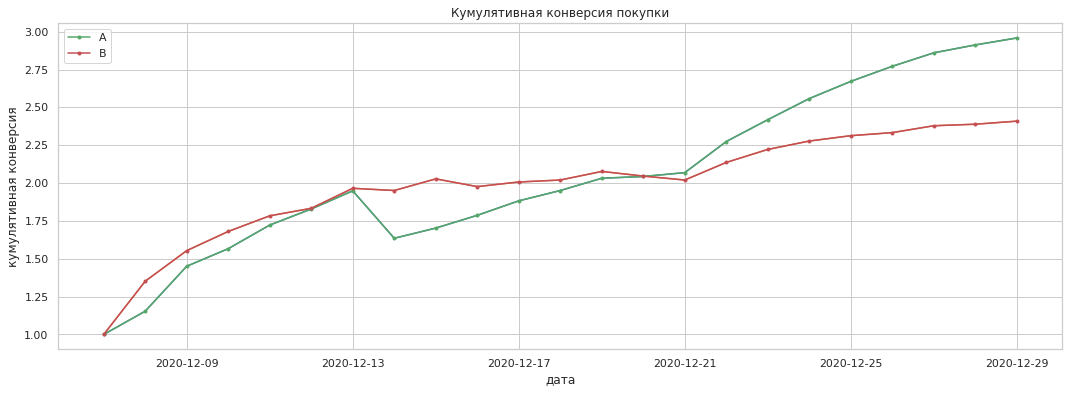

In [41]:
# анлогично для покупки
cumulativeData_purchase = cumulative_data(df_all_data, 'purchase')
cumulativeData_purchase['conversion'] = cumulativeData_purchase['orders']/cumulativeData_purchase['visitors']
cumulativeData_purchase_A = cumulativeData_purchase.query('group == "A"')
cumulativeData_purchase_B = cumulativeData_purchase.query('group == "B"')

# построение графика
plot_conversion(cumulativeData_purchase_A, cumulativeData_purchase_B, 'conversion', 'date',
          'Кумулятивная конверсия покупки', 'кумулятивная конверсия')

Для показателя кумулятивной конверсии покупок наблюдается в целом схожая тенденция:

- до 13 декабря показатель группы B немного превышает показатель группы A;
- далее конверсия покупок в группе A устанавливается на постоянном уровне около 2, а конверсия группы B резко падает 14 декабря;
- после чего конверсия группы B стабильно растет и с 21 декабря превосходит показатель группы A (который тоже начинает расти, но медленнее).

### Относительное изменение кумулятивной конверсии

Согласно ТЗ ожидается увеличение не менее чем на 10% каждой из метрик:

- конверсии в просмотр карточек товаров — событие product_page ,
- просмотры корзины — product_cart ,
- покупки — purchase .
Чтобы оценить изменения построим графики относительного изменениея конверсий группы В к группе А на каждом из шагов.

Чтобы оценить изменения построим графики относительного изменениея конверсий группы В к группе А на каждом из шагов.

In [42]:
def plot_relative_change(cumulativeDataA, cumulativeDataB, title):
    
    """
        Функция для построение относительного изменения кумулятивной конверсии между двумя группами
    
    """
    
    # собираем данные в одном датафрейме
    mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
    
    # задаем размер поля
    plt.subplots(figsize=(20,7))
    
    # cтроим отношение средних данных
    plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
    plt.legend()
    
    
    # добавляем ось X
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=0.1, color='grey', linestyle='--')
    plt.axis([dt.datetime(2020, 12, 7), dt.datetime(2020, 12, 29), -0.3, 0.3])
    
    # размер шрифта по оси x
    plt.tick_params(axis='x', which='major', labelsize=15)

    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Кумулятивная конверсия')

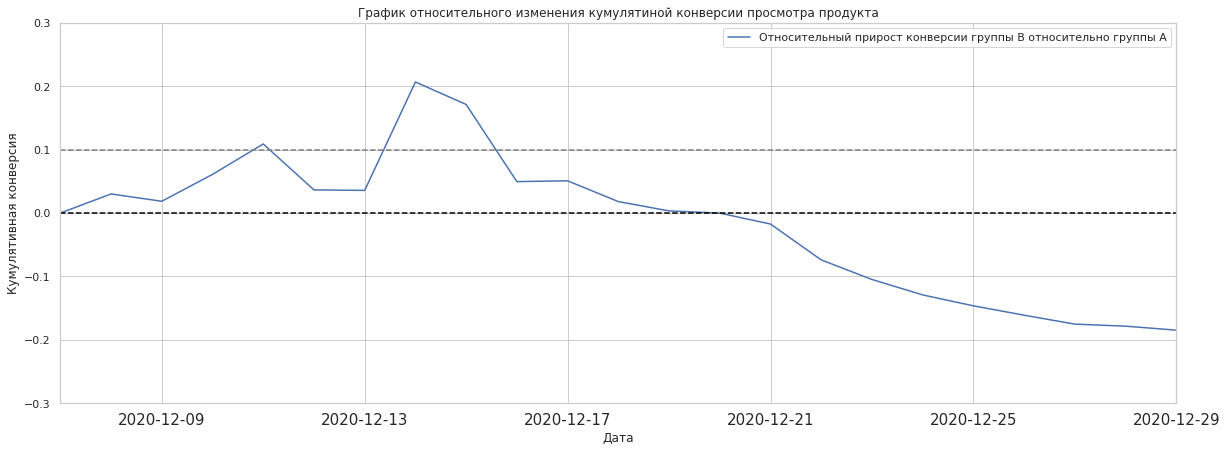

In [43]:
# построение графика относительного изменения кумулятиной конверсии просмотра продукта
plot_relative_change (cumulativeData_product_page_A, cumulativeData_product_page_B, 
                      'График относительного изменения кумулятиной конверсии просмотра продукта')

- в начале теста группа B превосходила группу A по показателю кумулятивной конверсии в просмотр карточек:
- с 14 декабря наблюдается стабильное снижение показателя метрики в группе B.
- с 20 декабря группа A вырвалась вперёд, а группа B стала показывать худшие результаты по относительному показателю, которые стабильно ухудшались до окончания теста.

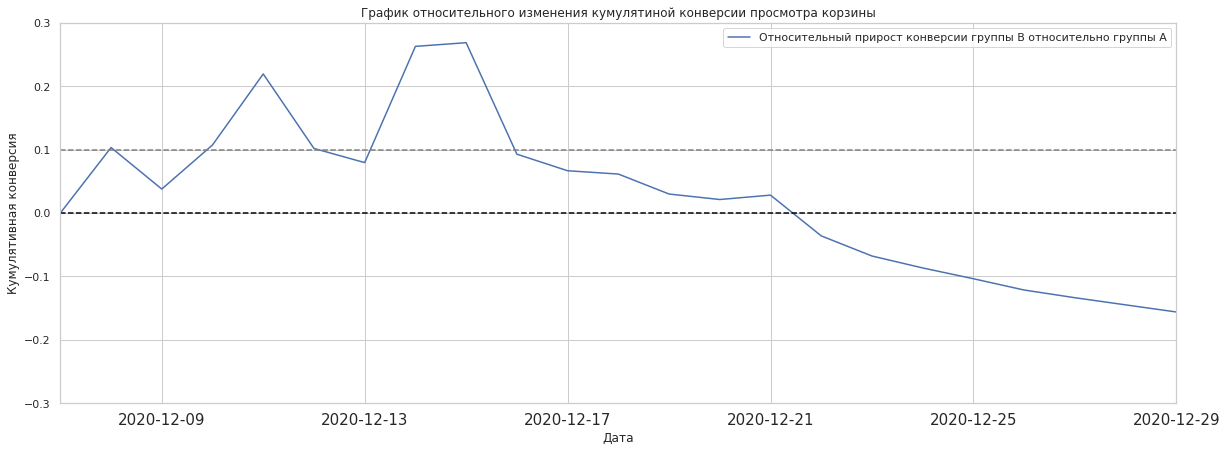

In [44]:
# построение графика относительного изменения кумулятиной конверсии просмотра корзины
plot_relative_change (cumulativeData_product_cart_A, cumulativeData_product_cart_B,
                     'График относительного изменения кумулятиной конверсии просмотра корзины')

Схожую ситуацию наблюдаем и по относительному показателю просмотров корзины:

- в начале теста группа B превосходила тоже группу A;
- с 16 декабря наблюдается стабильное снижение показателя метрики в группе B;
- с 22 декабря группа A вырвалась вперёд, а группа B стала показывать худшие результаты по относительному показателю, которые стабильно ухудшались до окончания теста.

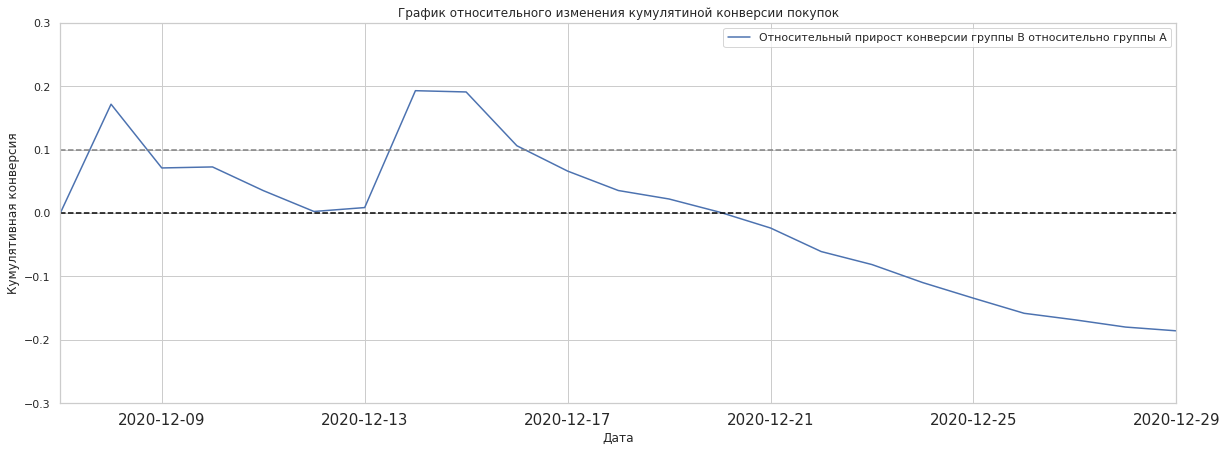

In [45]:
# построение гарфика относительного изменения кумулятиной конверсии покупок
plot_relative_change (cumulativeData_purchase_A, cumulativeData_purchase_B,
                     'График относительного изменения кумулятиной конверсии покупок')

С покупками уже ожидаемо картина аналогична, необольшая разница только в датах, когда начало происходить снижение:

- в начале теста группа B превосходила тоже группу A;
- с 15 декабря наблюдается стабильное снижение показателя метрики в группе B;
- с 20 декабря группа A вырвалась вперёд, а группа B стала показывать худшие результаты по относительному показателю, которые стабильно ухудшались до окончания теста.

Так же, посмотрим на изменение метрик в процентном соотношении 

In [46]:
#создаем табличку по столбцам 'lifetime', 'group', 'event_name' и с кол-вом событий
conversion = (participants_events.groupby(['lifetime', 'group', 'event_name'], as_index=False)['user_id'].count()
                  .rename(columns={'user_id':'events_count'}))
conversion.head()

,lifetime,group,event_name,events_count
0,0.0,A,login,2073
1,0.0,A,product_cart,630
2,0.0,A,product_page,1357
3,0.0,A,purchase,650
4,0.0,B,login,694


In [47]:
# создаем датафрейм с событиями product_page
product_pages = conversion.query('event_name == "product_page"')
# добавляем расчёт cumsum от количества событий
product_pages['events_cumsum'] = product_pages.groupby('group')['events_count'].cumsum()

# расчёт роста количества событий типа product_page для двух групп за 14 дней лайфтайма
a_product_pages = round((product_pages.iloc[-2]['events_cumsum'] - product_pages.iloc[0]['events_cumsum']) 
                        / product_pages.iloc[0]['events_cumsum'], 3) 
b_product_pages = round((product_pages.iloc[-1]['events_cumsum'] - product_pages.iloc[1]['events_cumsum']) 
                        / product_pages.iloc[1]['events_cumsum'], 3) 

/tmp/ipykernel_1015/3643218439.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
# аналогичные действия для события product_cart

product_carts = conversion.query('event_name == "product_cart"')
product_carts['events_cumsum'] = product_carts.groupby('group')['events_count'].cumsum()

#расчёт роста количества событий типа product_cart для двух групп за 14 дней лайфтайма
a_product_carts = round((product_carts.iloc[-2]['events_cumsum'] - product_carts.iloc[0]['events_cumsum']) 
                        / product_carts.iloc[0]['events_cumsum'], 3) 
b_product_carts = round((product_carts.iloc[-1]['events_cumsum'] - product_carts.iloc[1]['events_cumsum']) 
                        / product_carts.iloc[1]['events_cumsum'], 3)

/tmp/ipykernel_1015/3603666536.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
# аналогичные действия для события purchases

#датафрейм только с событиями типа purchases
purchases = conversion.query('event_name == "purchase"')
purchases['events_cumsum'] = purchases.groupby('group')['events_count'].cumsum()

#расчёт роста количества событий типа purchases для двух групп за 14 дней лайфтайма
a_purchases = round((purchases.iloc[-2]['events_cumsum'] - purchases.iloc[0]['events_cumsum']) 
                     / purchases.iloc[0]['events_cumsum'], 3) 
b_purchases = round((purchases.iloc[-1]['events_cumsum'] - purchases.iloc[1]['events_cumsum']) 
                    / purchases.iloc[1]['events_cumsum'], 3)

/tmp/ipykernel_1015/1270745560.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
# выводим получившиеся рез-ты

print("Группа А - просмотр страницы товара:", a_product_pages)
print("Группа B - просмотр страницы товара:", b_product_pages, end='\n\n')
print('---------------------------------------------------------------------------------------------------------')
print("Группа A - добавление товара в корзину:", a_product_carts)
print("Группа B - добавление товара в корзину:", b_product_carts, end='\n\n')
print('---------------------------------------------------------------------------------------------------------')
print("Группа А - покупки:", a_purchases)
print("Группа B - покупки:", b_purchases)

Группа А - просмотр страницы товара: 2.041
Группа B - просмотр страницы товара: 1.524

---------------------------------------------------------------------------------------------------------
Группа A - добавление товара в корзину: 2.079
Группа B - добавление товара в корзину: 1.635

---------------------------------------------------------------------------------------------------------
Группа А - покупки: 1.968
Группа B - покупки: 1.446


### Статистическая разница долей

Оценим статистическую значимость разницы среднего количества пользователей, совершивших значимые действия product_cart, product_page, purchase. Согласно условию задачи, для проверки будем использовать z-критерий.

Опишем функцию для проверки статистической разницы долей z-критерием.

Сформулируем гипотезы. Под значимым событием понимаются действия product_cart, product_page, purchase.

**H0:Доли значений метрик в группах равны**

**H1:Доли значений метрик в группах не равны**

In [51]:
#таблица по lifetime, group, + количество событий
users_count = (participants_events.groupby(['lifetime','group'], as_index=False)['user_id'].nunique()
               .rename(columns={'user_id':'users_count'}))

#события типа product_page
product_pages = product_pages.merge(users_count, on=['lifetime', 'group'])
product_pages['event_by_user'] = product_pages['events_count'] / product_pages['users_count']

#события типа product_cart
product_carts = product_carts.merge(users_count, on=['lifetime', 'group'])
product_carts['event_by_user'] = product_carts['events_count'] / product_carts['users_count']

#события типа purchase
purchases = purchases.merge(users_count, on=['lifetime', 'group'])
purchases['event_by_user'] = purchases['events_count'] / purchases['users_count']

In [52]:
# смотрим на средние значения ключевых метрик
print('Тип события product_pages')
display(product_pages.groupby('group')['event_by_user'].mean())
print('Тип события product_carts')
display(product_carts.groupby('group')['event_by_user'].mean())
print('Тип события purchases')
display(purchases.groupby('group')['event_by_user'].mean())

Тип события product_pages


group
A    0.649682
B    0.516244
Name: event_by_user, dtype: float64

Тип события product_carts


group
A    0.306943
B    0.274925
Name: event_by_user, dtype: float64

Тип события purchases


group
A    0.298587
B    0.245304
Name: event_by_user, dtype: float64

Можно заметить, что наибольшее отличие в количестве событий на пользователя для метрики product_pages, для остальных метрик разницы в значениях почти нет.

In [53]:
# функция для расчета z-test
def func_z_test(event_name):
    z_test = ztest(event_name.query('group == "A"')['event_by_user'], 
                   event_name.query('group == "B"')['event_by_user'], value=0)[1]
    print("p-value:", z_test)

In [54]:
func_z_test(product_pages)

p-value: 4.295825974356236e-08


In [55]:
func_z_test(product_carts)

p-value: 0.03176333477796466


In [56]:
func_z_test(purchases)

p-value: 0.0028200031917980607


**Вывод:**

На данном шаге мы построили кумулятивные графики конверсий и подробно описали их.

В целом относительные метрики показывают провальные результаты теста, целевые значения в группе B не только не увеличились на искомые 10% относительно А, а наоборот ухудшились.

Касаемо относительной конверсии по всем ключевым событиям можно сказать следующее:

- в начале теста группа B превосходила группу A по показателю кумулятивной конверсии в просмотр карточек:
- с 14 - 16 декабря наблюдается стабильное снижение всех показателей метрик в группе B.
- с 20 - 22 декабря группа A вырвалась вперёд, а группа B стала показывать худшие результаты по относительному показателю всех метрик, которые стабильно ухудшались до окончания теста.

Наблюдается статистическая разница долей групп А и B для события product_page. Для остальных событий статистической разницы не обнаружено.

Необходимо выяснить что поризошло на сайте 29-30 декабря. Похоже, что проходили какие - то обновления связанные с корзиной и покупкой, как следствие группа А перестала видеть корзину, такого рода изменения могли сказаться на конверсии в группах и дополнительно исказить результаты теста

## Общий вывод

Проведя исследование, можно дать рекомендацию о том, что тест необходимо продолжить . Однако следует увеличить количество пользователей в группе B.

Несмотря на то, что все целевые показатели в группе В не только не увеличились, а наоборот ухудшились относительно группы А, однозначно утверждать, что тест неудачен нельзя. Показатели разнились долгое время и окончательное утверждение группы А в качестве лидера по конверсии всех показателей произошло только в районе 20-22 декабря, когда в эту группу влили большое количество новых пользователей.

В случае принятия решения о продлении тестирования по его завершении дополнительно следует изучить данные о среднем чеке и ключевые метрики в разрезе устройств. Это может полезно, однако в рамках данного исследования такая задача не ставилась.

На сегодняшний день можно дополнительно дать следующие рекомендации:

**Данные:**

- пользователи в группах распределены неравномерно имется значительный перекос в пользу группы А;
- нет данных о последней неделе теста;
- тест по времени пересекается с новогодней маркетинговой акцией.

**Рекомендации:**

- проверить и по возможности исправить технические алгоритмы по разделению на группы;
- выяснить у ответственных сотрудников, что произошло с данными за последниюю неделю теста и что за работы происходили 29-30 декабря.

**Конверсия:**

- на каждом шаге мы теряем довольно большое количество пользователей (порядка половины)
- оценить конверсию между корзиной и покупкой невозможно из - за особенностей сайта заказчика